# Rede Neural Multi Layer Perceptron (MLP)

**Descrição**  
Este notebook apresenta a implementação didática de uma Rede Neural do tipo *Multi Layer Perceptron (MLP)*, construída do zero utilizando apenas NumPy. A arquitetura considerada possui uma única camada oculta com função de ativação logística (sigmoid) e uma camada de saída linear. O foco é compreender, de forma matemática e computacional, como redes neurais multicamadas superam as limitações dos neurônios lineares.

**Objetivo**  
Demonstrar como a introdução de uma camada oculta com não linearidade permite à rede neural aproximar funções não lineares, como funções periódicas ou altamente curvas, que não podem ser representadas adequadamente por modelos lineares. Além disso, o notebook busca consolidar o entendimento do algoritmo de *backpropagation* aplicado ao erro quadrático médio (EQM).

**Funcionamento** 

![MLP](../../imagens/06_mlp.png)

A MLP recebe valores de entrada e os propaga até a camada oculta, onde cada neurônio aplica uma transformação linear seguida da função logística. As ativações da camada oculta são então combinadas linearmente na camada de saída para produzir a predição final. O erro entre a saída predita e o valor real é medido pelo erro quadrático médio, e os gradientes desse erro em relação aos pesos e vieses são calculados por meio da regra da cadeia (*backpropagation*). Os parâmetros da rede são atualizados iterativamente via gradiente descendente, permitindo que o modelo aprenda representações não lineares dos dados.

**Matricialmente**

![MLP](../../imagens/06_mlp_matricial.png)


In [1]:
import matplotlib.pyplot as plt
import numpy as np

## Definição da função de ativação

In [2]:
def sigmoid(z: np.ndarray) -> np.ndarray:
    """
    Função logística (sigmoid).
    """
    return 1.0 / (1.0 + np.exp(-z))


def sigmoid_derivada(z: np.ndarray) -> np.ndarray:
    """
    Derivada da função logística em relação a z.
    """
    s = sigmoid(z)
    return s * (1 - s)

In [3]:
x = np.linspace(-10, 10, 400)

y_logsig = sigmoid(x)
y_derivada = sigmoid_derivada(x)

## Gráfico da função de ativação e sua derivada

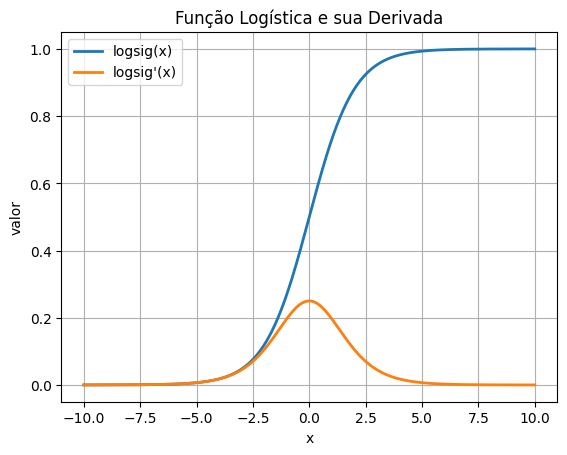

In [4]:
plt.figure()
plt.plot(x, y_logsig, label="logsig(x)", linewidth=2)
plt.plot(x, y_derivada, label="logsig'(x)", linewidth=2)
plt.title("Função Logística e sua Derivada")
plt.xlabel("x")
plt.ylabel("valor")
plt.legend()
plt.grid(True)
plt.show()

## Definição da MLP

In [5]:
class MLP:
    """
    MLP com:
    - 1 camada oculta (sigmoid)
    - camada de saída linear
    """

    def __init__(self, n_hidden: int, lr: float = 0.01, seed: int = 42):
        rng = np.random.default_rng(seed)

        self.W1 = rng.uniform(-1, 1, size=(n_hidden, 1))
        self.b1 = rng.uniform(-1, 1, size=(n_hidden, 1))

        self.W2 = rng.uniform(-1, 1, size=(1, n_hidden))
        self.b2 = rng.uniform(-1, 1, size=(1, 1))

        self.lr = lr

        # Histórico
        self.historico_erro = []
        self.historico_norma_grad = []
        self.historico_norma_pesos = []  # ← NOVO

    def forward(self, x: np.ndarray) -> dict:
        x = x.reshape(1, -1)

        z1 = self.W1 @ x + self.b1
        a1 = sigmoid(z1)

        z2 = self.W2 @ a1 + self.b2
        y_hat = z2

        return {"x": x, "z1": z1, "a1": a1, "y_hat": y_hat}

    @staticmethod
    def mse(y: np.ndarray, y_hat: np.ndarray) -> float:
        return np.mean((y - y_hat) ** 2)

    def backward(self, y: np.ndarray, cache: dict) -> None:
        x = cache["x"]
        z1 = cache["z1"]
        a1 = cache["a1"]
        y_hat = cache["y_hat"]

        y = y.reshape(1, -1)
        N = y.shape[1]

        # Gradiente da saída
        dL_dy = -2 * (y - y_hat) / N

        dW2 = dL_dy @ a1.T
        db2 = np.sum(dL_dy, axis=1, keepdims=True)

        da1 = self.W2.T @ dL_dy
        dz1 = da1 * sigmoid_derivada(z1)

        dW1 = dz1 @ x.T
        db1 = np.sum(dz1, axis=1, keepdims=True)

        norma_grad = np.sqrt(
            np.sum(dW1**2) + np.sum(db1**2) + np.sum(dW2**2) + np.sum(db2**2)
        )
        self.historico_norma_grad.append(norma_grad)

        norma_pesos = np.sqrt(
            np.sum(self.W1**2)
            + np.sum(self.b1**2)
            + np.sum(self.W2**2)
            + np.sum(self.b2**2)
        )
        self.historico_norma_pesos.append(norma_pesos)

        # Atualização dos parâmetros
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1

    def treinar(self, x: np.ndarray, y: np.ndarray, epocas: int = 2000) -> None:
        for _ in range(epocas):
            cache = self.forward(x)
            erro = self.mse(y, cache["y_hat"])
            self.historico_erro.append(erro)
            self.backward(y, cache)

## Utilização da MLP para aproximar uma função seno

In [6]:
# Dados
x = np.linspace(0, 2 * np.pi, 300)
y = np.sin(x)

# Modelo
mlp = MLP(n_hidden=2, lr=0.05)
mlp.treinar(x, y, epocas=5000)

# Predição
y_pred = mlp.forward(x)["y_hat"].flatten()

## Gráfico da aproximação

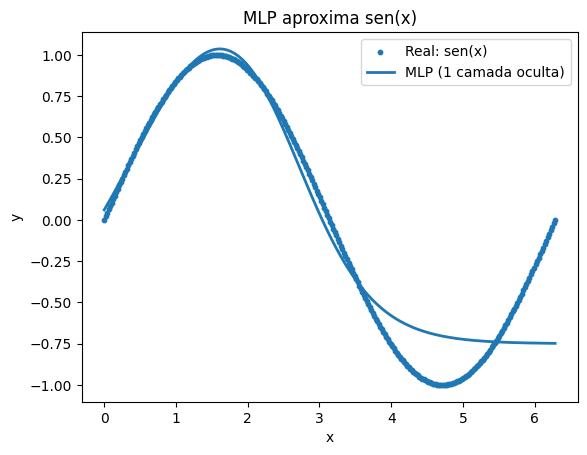

In [7]:
plt.figure()
plt.scatter(x, y, s=10, label="Real: sen(x)")
plt.plot(x, y_pred, linewidth=2, label="MLP (1 camada oculta)")
plt.title("MLP aproxima sen(x)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

## Gráfico do EQM durante o treinamento

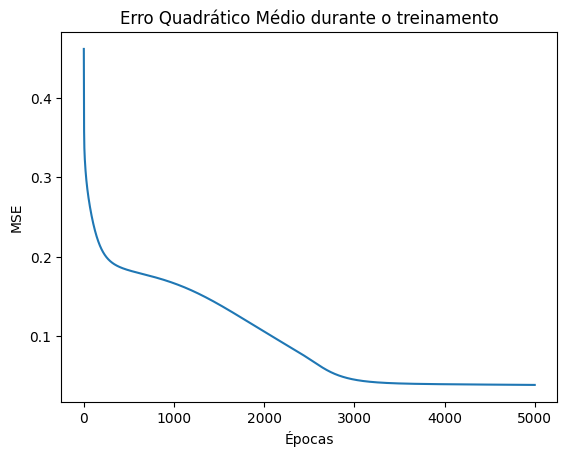

In [8]:
plt.figure()
plt.plot(mlp.historico_erro)
plt.title("Erro Quadrático Médio durante o treinamento")
plt.xlabel("Épocas")
plt.ylabel("MSE")
plt.show()

## Norma 2 dos gradientes

https://editor.codecogs.com/home

Considerando os pesos:

<img src="https://latex.codecogs.com/svg.image?\Theta=\{W^{(1)},b^{(1)},W^{(2)},b^{(2)}\}" title="\Theta=\{W^{(1)},b^{(1)},W^{(2)},b^{(2)}\}" />

O gradiente da perda em relação aos parâmetros é dado por:

<img src="https://latex.codecogs.com/svg.image?\nabla_{\Theta}\mathcal{L}=\left\{\frac{\partial\mathcal{L}}{\partial&space;W^{(1)}},\frac{\partial\mathcal{L}}{\partial&space;b^{(1)}},\frac{\partial\mathcal{L}}{\partial&space;W^{(2)}},\frac{\partial\mathcal{L}}{\partial&space;b^{(2)}}\right\}" title="\nabla_{\Theta}\mathcal{L}=\left\{\frac{\partial\mathcal{L}}{\partial W^{(1)}},\frac{\partial\mathcal{L}}{\partial b^{(1)}},\frac{\partial\mathcal{L}}{\partial W^{(2)}},\frac{\partial\mathcal{L}}{\partial b^{(2)}}\right\}" />

A norma 2 (euclidiana) do gradiente é definida como:

<img src="https://latex.codecogs.com/svg.image?\boxed{\left\|\nabla_{\Theta}\mathcal{L}\right\|_2=\sqrt{\left\|\frac{\partial\mathcal{L}}{\partial&space;W^{(1)}}\right\|_F^2&plus;\left\|\frac{\partial\mathcal{L}}{\partial&space;b^{(1)}}\right\|_2^2&plus;\left\|\frac{\partial\mathcal{L}}{\partial&space;W^{(2)}}\right\|_F^2&plus;\left\|\frac{\partial\mathcal{L}}{\partial&space;b^{(2)}}\right\|_2^2}}" title="\boxed{\left\|\nabla_{\Theta}\mathcal{L}\right\|_2=\sqrt{\left\|\frac{\partial\mathcal{L}}{\partial W^{(1)}}\right\|_F^2+\left\|\frac{\partial\mathcal{L}}{\partial b^{(1)}}\right\|_2^2+\left\|\frac{\partial\mathcal{L}}{\partial W^{(2)}}\right\|_F^2+\left\|\frac{\partial\mathcal{L}}{\partial b^{(2)}}\right\|_2^2}}" />

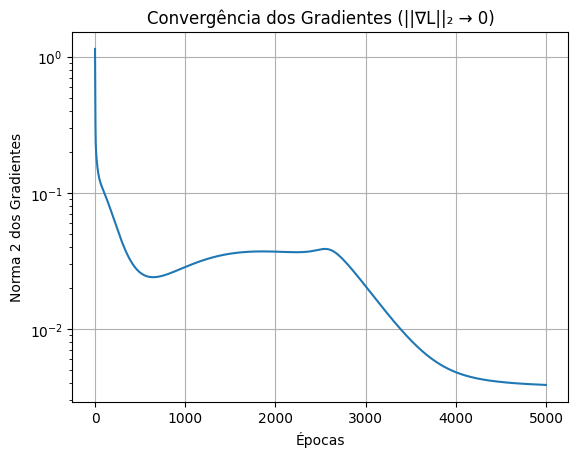

In [9]:
plt.figure()
plt.plot(mlp.historico_norma_grad)
plt.xlabel("Épocas")
plt.ylabel("Norma 2 dos Gradientes")
plt.title("Convergência dos Gradientes (||∇L||₂ → 0)")
plt.yscale("log")  # opcional, mas altamente recomendado
plt.grid(True)
plt.show()

## Norma 2 dos pesos

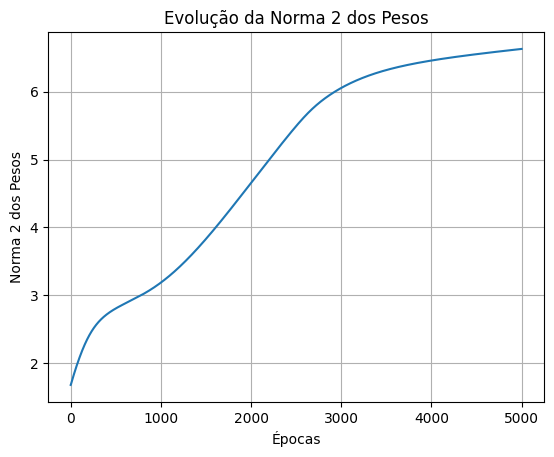

In [10]:
plt.figure()
plt.plot(mlp.historico_norma_pesos)
plt.xlabel("Épocas")
plt.ylabel("Norma 2 dos Pesos")
plt.title("Evolução da Norma 2 dos Pesos")
plt.grid(True)
plt.show()